In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import os
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime
from datetime import date, timedelta
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

data_path = 'D:/universidad/universidad 4/TFG/recursos para el desarrollo/datos procesados/OD'

In [2]:
delta = e_date - i_date

target_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    target_days.append(day)

In [3]:
def read_OD_fn(source_type):
    ods = {}
    for date in tqdm_notebook(target_days):
        od_date= pd.read_csv(os.path.join(data_path, 'date_{}_OD_{}.csv'.format(source_type,date.strftime('%Y-%m-%d'))), 
                            index_col=0)
        ods[date] = od_date
    return ods

In [4]:
ine_ods = read_OD_fn('INE')

  0%|          | 0/81 [00:00<?, ?it/s]

# Serializar los datos

In [5]:
lista_ine1 = []
lista_ine2 = []
lista_ine3 = []
lista_ine4 = []
lista_ine5 = []

for date in tqdm_notebook(target_days):
    lista_ine1.append(ine_ods[date].loc['18GU','total'])
    lista_ine2.append(ine_ods[date].loc['013B','total'])
    lista_ine3.append(ine_ods[date].loc['021S','total'])
    lista_ine4.append(ine_ods[date].loc['219M','total'])
    lista_ine5.append(ine_ods[date].loc['01CA','total'])

  0%|          | 0/81 [00:00<?, ?it/s]

In [6]:
df_ine1 = pd.DataFrame (lista_ine1, columns = ['Viajes'], index= target_days)
df_ine2 = pd.DataFrame (lista_ine2, columns = ['Viajes'], index= target_days)
df_ine3 = pd.DataFrame (lista_ine3, columns = ['Viajes'], index= target_days)
df_ine4 = pd.DataFrame (lista_ine4, columns = ['Viajes'], index= target_days)
df_ine5 = pd.DataFrame (lista_ine5, columns = ['Viajes'], index= target_days)

In [7]:
lista_ine = []

df = df_ine1 + df_ine2 + df_ine3 + df_ine4 + df_ine5

In [8]:
df.head()

,Viajes
2020-04-01,3314
2020-04-02,3220
2020-04-03,3934
2020-04-04,3141
2020-04-05,2520


In [9]:
del ine_ods

# Visualización de datos

In [10]:
print(df.index.min())
print(df.index.max())

2020-04-01 00:00:00
2020-06-20 00:00:00


In [11]:
print(len(df['2020']))

81


In [12]:
df.describe()

,Viajes
count,81.000000
mean,4188.802469
std,922.684743
min,2282.000000
25%,3503.000000
50%,4243.000000
75%,4933.000000
max,5827.000000


In [13]:
meses = df.resample('M').mean()
meses

,Viajes
2020-04-30,3410.966667
2020-05-31,4262.193548
2020-06-30,5241.800000


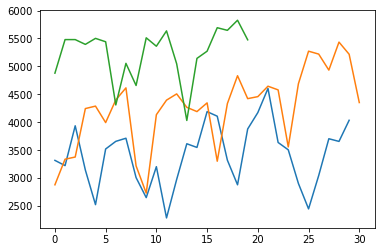

In [14]:
abril = df['2020-04-01':'2020-04-30']
plt.plot(abril.values)
mayo = df['2020-05-01':'2020-05-31']
plt.plot(mayo.values)
junio = df['2020-06-01':'2020-06-20']
plt.plot(junio.values)

# Preprocesado de datos

In [15]:
# cantidad de dias previos que se usaran para predecir el siguiente dia 
look_back=7

# convertir series en conocimiento supervisado
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # secuencia de entrada (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # secuencia del pronostico (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # unimos todo
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # eliminamos todos los valores nulos
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# cargamos el dataframe en la variable values
values = df.values

# convertimos los enteros en floats
values = values.astype('float32')

# normalizamos los datos a escala de entre -1 y 1
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

# usamos la funcion definida previamente
reframed = series_to_supervised(scaled, look_back, 1)

# imprimimos los nuevos datos
reframed.tail()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
76,0.339916,0.822285,0.737095,0.892243,0.559380,-0.013822,0.614105,0.686883
77,0.822285,0.737095,0.892243,0.559380,-0.013822,0.614105,0.686883,0.924401
78,0.737095,0.892243,0.559380,-0.013822,0.614105,0.686883,0.924401,0.897885
79,0.892243,0.559380,-0.013822,0.614105,0.686883,0.924401,0.897885,1.000000
80,0.559380,-0.013822,0.614105,0.686883,0.924401,0.897885,1.000000,0.801975


# Dividimos los datos en sets de entrenamiento y validacion

In [16]:
# dividimos nuestro valores entre sets de entrenamiento y de test
values = reframed.values
n_train_days = 71 - (10+look_back)
train = values[:n_train_days, :]
test = values[n_train_days:, :]

# los volvemos a dividir en entradas y salidas
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]

# remodelamos la muestras para ser de las dimensiones [samples, timesteps, features]
trainX = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
testX = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))

print(trainX.shape, y_train.shape, testX.shape, y_val.shape)

(54, 1, 7) (54,) (20, 1, 7) (20,)


# Creamos la red neuronal

In [17]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(look_back, input_shape=(1,look_back),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(100, activation='tanh'))
    model.add(Dropout(0.30))
    model.add(Dense(100, activation='tanh'))
    model.add(Dropout(0.30))
    model.add(Dense(100, activation='tanh'))
    model.add(Dropout(0.30))
    model.add(Dense(100, activation='tanh'))
    model.add(Dropout(0.30))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [18]:
EPOCHS=200

model = crear_modeloFF()

history=model.fit(trainX,y_train,epochs=EPOCHS,validation_data=(testX,y_val),batch_size=look_back)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 7)              56        
_________________________________________________________________
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               800       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               1

8/8 [==============================] - 0s 6ms/step - loss: 0.3082 - mse: 0.1561 - val_loss: 0.1874 - val_mse: 0.0567
Epoch 50/200
8/8 [==============================] - 0s 7ms/step - loss: 0.2489 - mse: 0.1057 - val_loss: 0.1923 - val_mse: 0.0548
Epoch 51/200
8/8 [==============================] - 0s 6ms/step - loss: 0.2516 - mse: 0.0979 - val_loss: 0.1701 - val_mse: 0.0513
Epoch 52/200
8/8 [==============================] - 0s 6ms/step - loss: 0.2797 - mse: 0.1198 - val_loss: 0.1759 - val_mse: 0.0493
Epoch 53/200
8/8 [==============================] - 0s 6ms/step - loss: 0.2632 - mse: 0.1201 - val_loss: 0.1854 - val_mse: 0.0499
Epoch 54/200
8/8 [==============================] - 0s 6ms/step - loss: 0.2473 - mse: 0.0940 - val_loss: 0.2563 - val_mse: 0.0790
Epoch 55/200
8/8 [==============================] - 0s 6ms/step - loss: 0.3132 - mse: 0.1397 - val_loss: 0.2470 - val_mse: 0.0737
Epoch 56/200
8/8 [==============================] - 0s 7ms/step - loss: 0.2564 - mse: 0.0997 - val_loss

8/8 [==============================] - 0s 7ms/step - loss: 0.2279 - mse: 0.0842 - val_loss: 0.2262 - val_mse: 0.0626
Epoch 112/200
8/8 [==============================] - 0s 6ms/step - loss: 0.2147 - mse: 0.0721 - val_loss: 0.2201 - val_mse: 0.0607
Epoch 113/200
8/8 [==============================] - 0s 6ms/step - loss: 0.2200 - mse: 0.0716 - val_loss: 0.1983 - val_mse: 0.0537
Epoch 114/200
8/8 [==============================] - 0s 6ms/step - loss: 0.2734 - mse: 0.1034 - val_loss: 0.2246 - val_mse: 0.0627
Epoch 115/200
8/8 [==============================] - 0s 6ms/step - loss: 0.2067 - mse: 0.0708 - val_loss: 0.2264 - val_mse: 0.0655
Epoch 116/200
8/8 [==============================] - 0s 6ms/step - loss: 0.2475 - mse: 0.0935 - val_loss: 0.2254 - val_mse: 0.0644
Epoch 117/200
8/8 [==============================] - 0s 6ms/step - loss: 0.2532 - mse: 0.0951 - val_loss: 0.2309 - val_mse: 0.0652
Epoch 118/200
8/8 [==============================] - 0s 6ms/step - loss: 0.2875 - mse: 0.1108 - v

8/8 [==============================] - 0s 6ms/step - loss: 0.2548 - mse: 0.0929 - val_loss: 0.1685 - val_mse: 0.0495
Epoch 174/200
8/8 [==============================] - 0s 6ms/step - loss: 0.2520 - mse: 0.0909 - val_loss: 0.2080 - val_mse: 0.0558
Epoch 175/200
8/8 [==============================] - 0s 6ms/step - loss: 0.2262 - mse: 0.0807 - val_loss: 0.2483 - val_mse: 0.0719
Epoch 176/200
8/8 [==============================] - 0s 6ms/step - loss: 0.2610 - mse: 0.1007 - val_loss: 0.2315 - val_mse: 0.0638
Epoch 177/200
8/8 [==============================] - 0s 6ms/step - loss: 0.2227 - mse: 0.0688 - val_loss: 0.1982 - val_mse: 0.0518
Epoch 178/200
8/8 [==============================] - 0s 7ms/step - loss: 0.2382 - mse: 0.0920 - val_loss: 0.1808 - val_mse: 0.0484
Epoch 179/200
8/8 [==============================] - 0s 6ms/step - loss: 0.2445 - mse: 0.0866 - val_loss: 0.2065 - val_mse: 0.0546
Epoch 180/200
8/8 [==============================] - ETA: 0s - loss: 0.1811 - mse: 0.047 - 0s 6ms

# Visualizamos resultados

In [19]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


def compute_metrics_fn(y_valid_resc, y_hat_resc):
    mae_ = mean_absolute_error(y_valid_resc, y_hat_resc)
    mse_ = mean_squared_error(y_valid_resc, y_hat_resc)
    rmse_ = mean_squared_error(y_valid_resc, y_hat_resc, squared = False)
    cvrmse_ = rmse_/np.mean(y_valid_resc)*100
    mape_ = mape(y_valid_resc, y_hat_resc)
    
    return mae_, mse_, rmse_, cvrmse_, mape_

In [20]:
# hacemos las predicciones
trainPredict = model.predict(x_train)
testPredict = model.predict(x_val)

# invertimos las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY = y_train.reshape(y_train.shape[0], 1)
trainY_scalerInverse = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = y_val.reshape(y_val.shape[0], 1)
testY_scalerInverse = scaler.inverse_transform(testY)

In [21]:
# calculamos las metricas de error
trainScore_MAE, trainScore_MSE, trainScore_RMSE, trainScore_CVRMSE, trainScore_MAPE  =  compute_metrics_fn(trainY_scalerInverse, trainPredict)
print('Resultado del entrenamiento: %.2f MAE' % (trainScore_MAE))
print('Resultado del entrenamiento: %.2f MSE' % (trainScore_MSE))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore_RMSE))
print('Resultado del entrenamiento: %.2f CVRMSE' % (trainScore_CVRMSE))
print('Resultado del entrenamiento: %.2f MAPE \n' % (trainScore_MAPE))

testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(testY_scalerInverse, testPredict)
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del entrenamiento: 377.43 MAE
Resultado del entrenamiento: 232053.53 MSE
Resultado del entrenamiento: 481.72 RMSE
Resultado del entrenamiento: 12.32 CVRMSE
Resultado del entrenamiento: 10.37 MAPE 

Resultado del test: 389.28 MAE
Resultado del test: 188737.70 MSE
Resultado del test: 434.44 RMSE
Resultado del test: 8.29 CVRMSE
Resultado del test: 7.56 MAPE


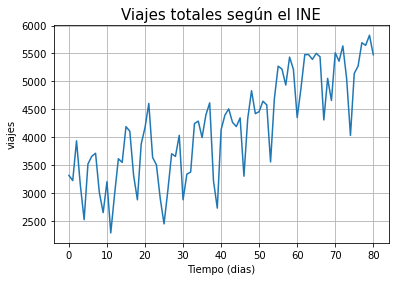

In [22]:
plt.plot(df.values)
plt.grid(True)
plt.title("Viajes totales según el INE", fontsize = 15)
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes", fontsize = 10)
plt.show()

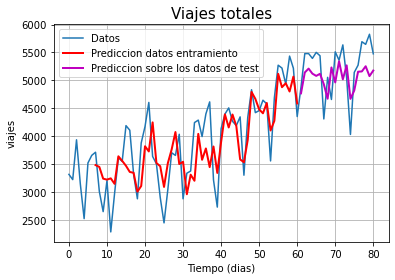

In [23]:
dataset = df.values
dataset = dataset.astype('float32')
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# predicciones del test de cambio para plotear
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back):len(dataset), :] = testPredict
# plot baseline and predictions
plt.plot(df.values)
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.title("Viajes totales", fontsize = 15)
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes", fontsize = 10)
plt.show()

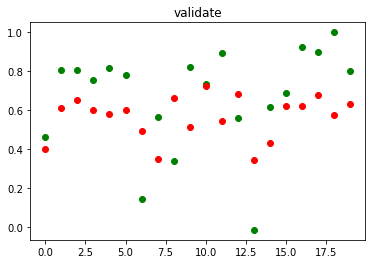

In [24]:
results=model.predict(x_val)

plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

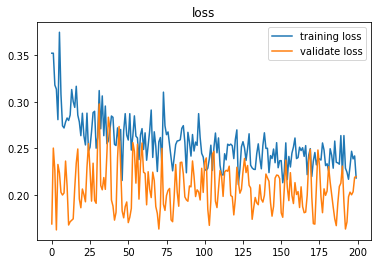

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.legend( ('training loss', 'validate loss'), loc = 'upper right')
plt.show()

# Prediccion a futuro

In [26]:
# usaremos los 14 ultimos dias del confinamiento en junio para predecir como habrian sido los dias del 21 al 27 en caso de que
# el confinamiento se hubiese alargado por una semana mas

ultimosDias = df['2020-6-7':'2020-6-20']
ultimosDias

,Viajes
2020-06-07,4308
2020-06-08,5054
2020-06-09,4657
2020-06-10,5512
2020-06-11,5361
2020-06-12,5636
2020-06-13,5046
2020-06-14,4030
2020-06-15,5143
2020-06-16,5272


# Preparamos los datos para el test

In [27]:
# cargamos el dataframe en la variable values
values = ultimosDias.values

# convertimos los enteros en floats
values = values.astype('float32')

# normalizamos los datos a escala de entre -1 y 1
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

# usamos la funcion definida previamente
reframed = series_to_supervised(scaled, look_back, 1)

# eliminamos la ultima columna pues es parte de lo que queremos hayar
reframed.drop(reframed.columns[[7]], inplace=True, axis=1)
reframed.head(7)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,-0.690595,0.139678,-0.302170,0.649416,0.481358,0.787424,0.130774
8,0.139678,-0.302170,0.649416,0.481358,0.787424,0.130774,-1.000000
9,-0.302170,0.649416,0.481358,0.787424,0.130774,-1.000000,0.238731
10,0.649416,0.481358,0.787424,0.130774,-1.000000,0.238731,0.382304
11,0.481358,0.787424,0.130774,-1.000000,0.238731,0.382304,0.850863
12,0.787424,0.130774,-1.000000,0.238731,0.382304,0.850863,0.798553
13,0.130774,-1.000000,0.238731,0.382304,0.850863,0.798553,1.000000


In [28]:
values = reframed.values

#tomamos los valores para realizar el test
x_test = values[6:, :]

# reshape input to be 3D [samples, timesteps, features]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
x_test

(1, 1, 7)


array([[[ 0.13077354, -1.        ,  0.23873138,  0.3823037 ,
          0.8508625 ,  0.79855347,  1.        ]]], dtype=float32)

In [29]:
#definimos la funcion para realizar el desplazamiento que se hara en el array cada prediccion pues para hacer
#la siguiente prediccion eliminamos el dia mas antiguo, desplazamos un lugar el resto de dias y añadimos el ultimo dia que
#se ha predecido, esto es por que para predecir un dia se usan los 7 dias previos

def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

# Predicciones para la proxima semana

In [30]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

[[[ 0.13077354 -1.          0.23873138  0.3823037   0.8508625
    0.79855347  1.        ]]]
[[[-1.          0.23873138  0.3823037   0.8508625   0.79855347
    1.          0.4994262 ]]]
[[[ 0.23873138  0.3823037   0.8508625   0.79855347  1.
    0.4994262  -0.18612331]]]
[[[ 0.3823037   0.8508625   0.79855347  1.          0.4994262
   -0.18612331  0.29235867]]]
[[[ 0.8508625   0.79855347  1.          0.4994262  -0.18612331
    0.29235867  0.5809681 ]]]
[[[ 0.79855347  1.          0.4994262  -0.18612331  0.29235867
    0.5809681   0.6703724 ]]]
[[[ 1.          0.4994262  -0.18612331  0.29235867  0.5809681
    0.6703724   0.6607141 ]]]


# Re-Convertimos los resultados

In [31]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([0.4994262], dtype=float32), array([-0.18612331], dtype=float32), array([0.29235867], dtype=float32), array([0.5809681], dtype=float32), array([0.6703724], dtype=float32), array([0.6607141], dtype=float32), array([0.60813934], dtype=float32)]


array([[5377.23433037],
       [4761.26813179],
       [5191.18417172],
       [5450.49972082],
       [5530.82952115],
       [5522.15150603],
       [5474.91309169]])

# Visualizamos el pronostico

<AxesSubplot:>

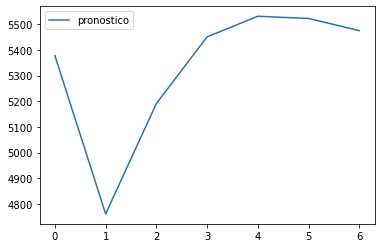

In [32]:
prediccion = pd.DataFrame(inverted)
prediccion.columns = ['pronostico']
prediccion.plot()

# Prediccion con datos actuales

In [33]:
# usaremos 14 dias que poseemos para predecir los 7 dias siguientes tras esto compararemos los resultados con los que
# poseemos para ver el grado de error

Dias = df['2020-5-11':'2020-5-24']
Dias

,Viajes
2020-05-11,4133
2020-05-12,4394
2020-05-13,4506
2020-05-14,4265
2020-05-15,4189
2020-05-16,4345
2020-05-17,3299
2020-05-18,4333
2020-05-19,4832
2020-05-20,4421


# Preparamos los datos para el test

In [34]:
# cargamos el dataframe en la variable values
values = Dias.values

# convertimos los enteros en floats
values = values.astype('float32')

# normalizamos los datos a escala de entre -1 y 1
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

# usamos la funcion definida previamente
reframed = series_to_supervised(scaled, look_back, 1)

# eliminamos la ultima columna pues es parte de lo que queremos hayar
reframed.drop(reframed.columns[[7]], inplace=True, axis=1)
reframed.head(7)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,0.088062,0.428571,0.574690,0.260274,0.161122,0.364645,-1.000000
8,0.428571,0.574690,0.260274,0.161122,0.364645,-1.000000,0.348989
9,0.574690,0.260274,0.161122,0.364645,-1.000000,0.348989,1.000000
10,0.260274,0.161122,0.364645,-1.000000,0.348989,1.000000,0.463796
11,0.161122,0.364645,-1.000000,0.348989,1.000000,0.463796,0.510763
12,0.364645,-1.000000,0.348989,1.000000,0.463796,0.510763,0.754729
13,-1.000000,0.348989,1.000000,0.463796,0.510763,0.754729,0.668623


In [35]:
values = reframed.values

#tomamos los valores para realizar el test
x_test = values[6:, :]

# reshape input to be 3D [samples, timesteps, features] - preguntar
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
x_test

(1, 1, 7)


array([[[-1.        ,  0.34898853,  1.        ,  0.46379614,
          0.51076317,  0.7547293 ,  0.66862345]]], dtype=float32)

In [36]:
#en la linea 24 definimos la funcion para realizar el desplazamiento que se hara en el array cada prediccion pues para hacer
#la siguiente prediccion eliminamos el dia mas antiguo, desplazamos un lugar el resto de dias y añadimos el ultimo dia que
#se ha predecido, esto es por que para predecir un dia se usan los 7 dias previos, y que usaremos a continuación

# Realizamos la prediccion 

In [37]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

[[[-1.          0.34898853  1.          0.46379614  0.51076317
    0.7547293   0.66862345]]]
[[[ 0.34898853  1.          0.46379614  0.51076317  0.7547293
    0.66862345 -0.01514165]]]
[[[ 1.          0.46379614  0.51076317  0.7547293   0.66862345
   -0.01514165  0.28060895]]]
[[[ 0.46379614  0.51076317  0.7547293   0.66862345 -0.01514165
    0.28060895  0.6688533 ]]]
[[[ 0.51076317  0.7547293   0.66862345 -0.01514165  0.28060895
    0.6688533   0.6062827 ]]]
[[[ 0.7547293   0.66862345 -0.01514165  0.28060895  0.6688533
    0.6062827   0.5989704 ]]]
[[[ 0.66862345 -0.01514165  0.28060895  0.6688533   0.6062827
    0.5989704   0.5773526 ]]]


# Re-Convertimos los resultados

In [38]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)

#en nuestro problema no tienen sentido los decimales pues no se pueden hacer 0.5 viajes o 0.25 viajes
inverted = inverted.round()
inverted = inverted.astype(int)
inverted

[array([-0.01514165], dtype=float32), array([0.28060895], dtype=float32), array([0.6688533], dtype=float32), array([0.6062827], dtype=float32), array([0.5989704], dtype=float32), array([0.5773526], dtype=float32), array([0.57687485], dtype=float32)]


array([[4054],
       [4281],
       [4578],
       [4530],
       [4525],
       [4508],
       [4508]])

# Visualizamos el pronostico

<AxesSubplot:>

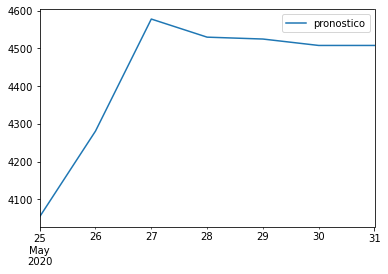

In [39]:
e_date = datetime.datetime.strptime('2020-05-31', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-05-25', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(inverted, index= index_days)
prediccion.columns = ['pronostico']
prediccion.plot()

In [40]:
datosReales = df['2020-5-25':'2020-5-31']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']
compara

,real,prediccion
2020-05-25,4688,4054
2020-05-26,5272,4281
2020-05-27,5220,4578
2020-05-28,4933,4530
2020-05-29,5435,4525
2020-05-30,5217,4508
2020-05-31,4351,4508


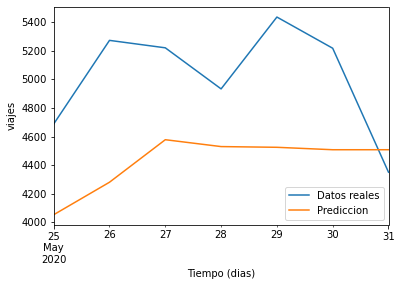

In [41]:
compara['real'].plot()
compara['prediccion'].plot()
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes", fontsize = 10)
plt.legend( ('Datos reales', 'Prediccion'), loc = 'lower right')

In [42]:
# calculamos las metricas de error
testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(prediccion, datosReales)
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del test: 635.14 MAE
Resultado del test: 473434.29 MSE
Resultado del test: 688.07 RMSE
Resultado del test: 15.54 CVRMSE
Resultado del test: 14.43 MAPE


In [43]:
# calculamos las metricas de error para cada dia por separado
for i in range(7):
    testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(prediccion.values[i], datosReales.values[i])
    day = i + 1
    print('Resultado del test dia %d: %.2f MAE' % (day, testScore_MAE))
    print('Resultado del test dia %d: %.2f MSE' % (day, testScore_MSE))
    print('Resultado del test dia %d: %.2f RMSE' % (day, testScore_RMSE))
    print('Resultado del test dia %d: %.2f CVRMSE' % (day, testScore_CVRMSE))
    print('Resultado del test dia %d: %.2f MAPE \n' % (day, testScore_MAPE))

Resultado del test dia 1: 634.00 MAE
Resultado del test dia 1: 401956.00 MSE
Resultado del test dia 1: 634.00 RMSE
Resultado del test dia 1: 15.64 CVRMSE
Resultado del test dia 1: 15.64 MAPE 

Resultado del test dia 2: 991.00 MAE
Resultado del test dia 2: 982081.00 MSE
Resultado del test dia 2: 991.00 RMSE
Resultado del test dia 2: 23.15 CVRMSE
Resultado del test dia 2: 23.15 MAPE 

Resultado del test dia 3: 642.00 MAE
Resultado del test dia 3: 412164.00 MSE
Resultado del test dia 3: 642.00 RMSE
Resultado del test dia 3: 14.02 CVRMSE
Resultado del test dia 3: 14.02 MAPE 

Resultado del test dia 4: 403.00 MAE
Resultado del test dia 4: 162409.00 MSE
Resultado del test dia 4: 403.00 RMSE
Resultado del test dia 4: 8.90 CVRMSE
Resultado del test dia 4: 8.90 MAPE 

Resultado del test dia 5: 910.00 MAE
Resultado del test dia 5: 828100.00 MSE
Resultado del test dia 5: 910.00 RMSE
Resultado del test dia 5: 20.11 CVRMSE
Resultado del test dia 5: 20.11 MAPE 

Resultado del test dia 6: 709.00 MAE
